In [6]:
# %load vaderSentiment.py
# Author: C.J. Hutto
# Thanks to George Berry for reducing the time complexity from something like O(N^4) to O(N).
# Thanks to Ewan Klein and Pierpaolo Pantone for bringing VADER into NLTK. Those modifications were awesome.
# For license information, see LICENSE.TXT

"""
If you use the VADER sentiment analysis tools, please cite:
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
"""

import math, re, string, requests, json
from itertools import product
from inspect import getsourcefile
from os.path import abspath, join, dirname

##Constants##

# (empirically derived mean sentiment intensity rating increase for booster words)
B_INCR = 0.293
B_DECR = -0.293

# (empirically derived mean sentiment intensity rating increase for using
# ALLCAPs to emphasize a word)
C_INCR = 0.733

N_SCALAR = -0.74

# for removing punctuation
REGEX_REMOVE_PUNCTUATION = re.compile('[%s]' % re.escape(string.punctuation))

PUNC_LIST = [".", "!", "?", ",", ";", ":", "-", "'", "\"",
             "!!", "!!!", "??", "???", "?!?", "!?!", "?!?!", "!?!?"]
NEGATE = \
["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
 "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
 "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
 "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
 "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
 "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
 "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
 "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

# booster/dampener 'intensifiers' or 'degree adverbs'
# http://en.wiktionary.org/wiki/Category:English_degree_adverbs

BOOSTER_DICT = \
{"absolutely": B_INCR, "amazingly": B_INCR, "awfully": B_INCR, "completely": B_INCR, "considerably": B_INCR,
 "decidedly": B_INCR, "deeply": B_INCR, "effing": B_INCR, "enormously": B_INCR,
 "entirely": B_INCR, "especially": B_INCR, "exceptionally": B_INCR, "extremely": B_INCR,
 "fabulously": B_INCR, "flipping": B_INCR, "flippin": B_INCR,
 "fricking": B_INCR, "frickin": B_INCR, "frigging": B_INCR, "friggin": B_INCR, "fully": B_INCR, "fucking": B_INCR,
 "greatly": B_INCR, "hella": B_INCR, "highly": B_INCR, "hugely": B_INCR, "incredibly": B_INCR,
 "intensely": B_INCR, "majorly": B_INCR, "more": B_INCR, "most": B_INCR, "particularly": B_INCR,
 "purely": B_INCR, "quite": B_INCR, "really": B_INCR, "remarkably": B_INCR,
 "so": B_INCR, "substantially": B_INCR,
 "thoroughly": B_INCR, "totally": B_INCR, "tremendously": B_INCR,
 "uber": B_INCR, "unbelievably": B_INCR, "unusually": B_INCR, "utterly": B_INCR,
 "very": B_INCR,
 "almost": B_DECR, "barely": B_DECR, "hardly": B_DECR, "just enough": B_DECR,
 "kind of": B_DECR, "kinda": B_DECR, "kindof": B_DECR, "kind-of": B_DECR,
 "less": B_DECR, "little": B_DECR, "marginally": B_DECR, "occasionally": B_DECR, "partly": B_DECR,
 "scarcely": B_DECR, "slightly": B_DECR, "somewhat": B_DECR,
 "sort of": B_DECR, "sorta": B_DECR, "sortof": B_DECR, "sort-of": B_DECR}

# check for special case idioms using a sentiment-laden keyword known to VADER
SPECIAL_CASE_IDIOMS = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "yeah right": -2,
                       "cut the mustard": 2, "kiss of death": -1.5, "hand to mouth": -2}


##Static methods##

def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    neg_words = []
    neg_words.extend(NEGATE)
    for word in neg_words:
        if word in input_words:
            return True
    if include_nt:
        for word in input_words:
            if "n't" in word:
                return True
    if "least" in input_words:
        i = input_words.index("least")
        if i > 0 and input_words[i-1] != "at":
            return True
    return False


def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score/math.sqrt((score*score) + alpha)
    if norm_score < -1.0: 
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score


def allcap_differential(words):
    """
    Check whether just some words in the input are ALL CAPS
    :param list words: The words to inspect
    :returns: `True` if some but not all items in `words` are ALL CAPS
    """
    is_different = False
    allcap_words = 0
    for word in words:
        if word.isupper():
            allcap_words += 1
    cap_differential = len(words) - allcap_words
    if cap_differential > 0 and cap_differential < len(words):
        is_different = True
    return is_different


def scalar_inc_dec(word, valence, is_cap_diff):
    """
    Check if the preceding words increase, decrease, or negate/nullify the
    valence
    """
    scalar = 0.0
    word_lower = word.lower()
    if word_lower in BOOSTER_DICT:
        scalar = BOOSTER_DICT[word_lower]
        if valence < 0:
            scalar *= -1
        #check if booster/dampener word is in ALLCAPS (while others aren't)
        if word.isupper() and is_cap_diff:
            if valence > 0:
                scalar += C_INCR
            else: scalar -= C_INCR
    return scalar

class SentiText(object):
    """
    Identify sentiment-relevant string-level properties of input text.
    """
    def __init__(self, text):
        if not isinstance(text, str):
            text = str(text.encode('utf-8'))
        self.text = text
        self.words_and_emoticons = self._words_and_emoticons()
        # doesn't separate words from\
        # adjacent punctuation (keeps emoticons & contractions)
        self.is_cap_diff = allcap_differential(self.words_and_emoticons)

    def _words_plus_punc(self):
        """
        Returns mapping of form:
        {
            'cat,': 'cat',
            ',cat': 'cat',
        }
        """
        no_punc_text = REGEX_REMOVE_PUNCTUATION.sub('', self.text)
        # removes punctuation (but loses emoticons & contractions)
        words_only = no_punc_text.split()
        # remove singletons
        words_only = set( w for w in words_only if len(w) > 1 )
        # the product gives ('cat', ',') and (',', 'cat')
        punc_before = {''.join(p): p[1] for p in product(PUNC_LIST, words_only)}
        punc_after = {''.join(p): p[0] for p in product(words_only, PUNC_LIST)}
        words_punc_dict = punc_before
        words_punc_dict.update(punc_after)
        return words_punc_dict

    def _words_and_emoticons(self):
        """
        Removes leading and trailing puncutation
        Leaves contractions and most emoticons
            Does not preserve punc-plus-letter emoticons (e.g. :D)
        """
        wes = self.text.split()
        words_punc_dict = self._words_plus_punc()
        wes = [we for we in wes if len(we) > 1]
        for i, we in enumerate(wes):
            if we in words_punc_dict:
                wes[i] = words_punc_dict[we]
        return wes

class SentimentIntensityAnalyzer(object):
    """
    Give a sentiment intensity score to sentences.
    """
    def __init__(self, lexicon_file="vader_lexicon.txt"):
        _this_module_file_path_ = abspath(getsourcefile(lambda:0))
        lexicon_full_filepath = join(dirname(_this_module_file_path_), lexicon_file)
        with open(lexicon_full_filepath, encoding='utf-8') as f:
            self.lexicon_full_filepath = f.read()
        self.lexicon = self.make_lex_dict()

    def make_lex_dict(self):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in self.lexicon_full_filepath.split('\n'):
            (word, measure) = line.strip().split('\t')[0:2]
            lex_dict[word] = float(measure)
        return lex_dict

    def polarity_scores(self, text):
        """
        Return a float for sentiment strength based on the input text.
        Positive values are positive valence, negative value are negative
        valence.
        """
        sentitext = SentiText(text)
        #text, words_and_emoticons, is_cap_diff = self.preprocess(text)

        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        for item in words_and_emoticons:
            valence = 0
            i = words_and_emoticons.index(item)
            if (i < len(words_and_emoticons) - 1 and item.lower() == "kind" and \
                words_and_emoticons[i+1].lower() == "of") or \
                item.lower() in BOOSTER_DICT:
                sentiments.append(valence)
                continue

            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

        sentiments = self._but_check(words_and_emoticons, sentiments)
        
        valence_dict = self.score_valence(sentiments, text)

        return valence_dict

    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            #get the sentiment valence
            valence = self.lexicon[item_lowercase]

            #check if sentiment laden word is in ALL CAPS (while others aren't)
            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += C_INCR
                else:
                    valence -= C_INCR

            for start_i in range(0,3):
                if i > start_i and words_and_emoticons[i-(start_i+1)].lower() not in self.lexicon:
                    # dampen the scalar modifier of preceding words and emoticons
                    # (excluding the ones that immediately preceed the item) based
                    # on their distance from the current item.
                    s = scalar_inc_dec(words_and_emoticons[i-(start_i+1)], valence, is_cap_diff)
                    if start_i == 1 and s != 0:
                        s = s*0.95
                    if start_i == 2 and s != 0:
                        s = s*0.9
                    valence = valence+s
                    valence = self._never_check(valence, words_and_emoticons, start_i, i)
                    if start_i == 2:
                        valence = self._idioms_check(valence, words_and_emoticons, i)

                        # future work: consider other sentiment-laden idioms
                        # other_idioms =
                        # {"back handed": -2, "blow smoke": -2, "blowing smoke": -2,
                        #  "upper hand": 1, "break a leg": 2,
                        #  "cooking with gas": 2, "in the black": 2, "in the red": -2,
                        #  "on the ball": 2,"under the weather": -2}

            valence = self._least_check(valence, words_and_emoticons, i)

        sentiments.append(valence)
        return sentiments

    def _least_check(self, valence, words_and_emoticons, i):
        # check for negation case using "least"
        if i > 1 and words_and_emoticons[i-1].lower() not in self.lexicon \
           and words_and_emoticons[i-1].lower() == "least":
            if words_and_emoticons[i-2].lower() != "at" and words_and_emoticons[i-2].lower() != "very":
                valence = valence*N_SCALAR
        elif i > 0 and words_and_emoticons[i-1].lower() not in self.lexicon \
             and words_and_emoticons[i-1].lower() == "least":
            valence = valence*N_SCALAR
        return valence

    def _but_check(self, words_and_emoticons, sentiments):
        # check for modification in sentiment due to contrastive conjunction 'but'
        if 'but' in words_and_emoticons or 'BUT' in words_and_emoticons:
            try:
                bi = words_and_emoticons.index('but')
            except ValueError:
                bi = words_and_emoticons.index('BUT')
            for sentiment in sentiments:
                si = sentiments.index(sentiment)
                if si < bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment*0.5)
                elif si > bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment*1.5)
        return sentiments

    def _idioms_check(self, valence, words_and_emoticons, i):
        onezero = "{0} {1}".format(words_and_emoticons[i-1], words_and_emoticons[i])

        twoonezero = "{0} {1} {2}".format(words_and_emoticons[i-2],
                                       words_and_emoticons[i-1], words_and_emoticons[i])

        twoone = "{0} {1}".format(words_and_emoticons[i-2], words_and_emoticons[i-1])

        threetwoone = "{0} {1} {2}".format(words_and_emoticons[i-3],
                                        words_and_emoticons[i-2], words_and_emoticons[i-1])

        threetwo = "{0} {1}".format(words_and_emoticons[i-3], words_and_emoticons[i-2])

        sequences = [onezero, twoonezero, twoone, threetwoone, threetwo]

        for seq in sequences:
            if seq in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[seq]
                break

        if len(words_and_emoticons)-1 > i:
            zeroone = "{0} {1}".format(words_and_emoticons[i], words_and_emoticons[i+1])
            if zeroone in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroone]
        if len(words_and_emoticons)-1 > i+1:
            zeroonetwo = "{0} {1} {2}".format(words_and_emoticons[i], words_and_emoticons[i+1], words_and_emoticons[i+2])
            if zeroonetwo in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroonetwo]

        # check for booster/dampener bi-grams such as 'sort of' or 'kind of'
        if threetwo in BOOSTER_DICT or twoone in BOOSTER_DICT:
            valence = valence+B_DECR
        return valence

    def _never_check(self, valence, words_and_emoticons, start_i, i):
        if start_i == 0:
            if negated([words_and_emoticons[i-1]]):
                    valence = valence*N_SCALAR
        if start_i == 1:
            if words_and_emoticons[i-2] == "never" and\
               (words_and_emoticons[i-1] == "so" or
                words_and_emoticons[i-1] == "this"):
                valence = valence*1.5
            elif negated([words_and_emoticons[i-(start_i+1)]]):
                valence = valence*N_SCALAR
        if start_i == 2:
            if words_and_emoticons[i-3] == "never" and \
               (words_and_emoticons[i-2] == "so" or words_and_emoticons[i-2] == "this") or \
               (words_and_emoticons[i-1] == "so" or words_and_emoticons[i-1] == "this"):
                valence = valence*1.25
            elif negated([words_and_emoticons[i-(start_i+1)]]):
                valence = valence*N_SCALAR
        return valence

    def _punctuation_emphasis(self, sum_s, text):
        # add emphasis from exclamation points and question marks
        ep_amplifier = self._amplify_ep(text)
        qm_amplifier = self._amplify_qm(text)
        punct_emph_amplifier = ep_amplifier+qm_amplifier
        return punct_emph_amplifier

    def _amplify_ep(self, text):
        # check for added emphasis resulting from exclamation points (up to 4 of them)
        ep_count = text.count("!")
        if ep_count > 4:
            ep_count = 4
        # (empirically derived mean sentiment intensity rating increase for
        # exclamation points)
        ep_amplifier = ep_count*0.292
        return ep_amplifier

    def _amplify_qm(self, text):
        # check for added emphasis resulting from question marks (2 or 3+)
        qm_count = text.count("?")
        qm_amplifier = 0
        if qm_count > 1:
            if qm_count <= 3:
                # (empirically derived mean sentiment intensity rating increase for
                # question marks)
                qm_amplifier = qm_count*0.18
            else:
                qm_amplifier = 0.96
        return qm_amplifier

    def _sift_sentiment_scores(self, sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (float(sentiment_score) +1) # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (float(sentiment_score) -1) # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

    def score_valence(self, sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))
            # compute and add emphasis from punctuation in text
            punct_emph_amplifier = self._punctuation_emphasis(sum_s, text)
            if sum_s > 0:
                sum_s += punct_emph_amplifier
            elif  sum_s < 0:
                sum_s -= punct_emph_amplifier

            compound = normalize(sum_s)
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            if pos_sum > math.fabs(neg_sum):
                pos_sum += (punct_emph_amplifier)
            elif pos_sum < math.fabs(neg_sum):
                neg_sum -= (punct_emph_amplifier)

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = \
            {"neg" : round(neg, 3),
             "neu" : round(neu, 3),
             "pos" : round(pos, 3),
             "compound" : round(compound, 4)}

        return sentiment_dict

if __name__ == '__main__':
    # --- examples -------
    sentences = ["VADER is smart, handsome, and funny.",      # positive sentence example
                "VADER is not smart, handsome, nor funny.",   # negation sentence example
                "VADER is smart, handsome, and funny!",       # punctuation emphasis handled correctly (sentiment intensity adjusted)
                "VADER is very smart, handsome, and funny.",  # booster words handled correctly (sentiment intensity adjusted)
                "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
                "VADER is VERY SMART, handsome, and FUNNY!!!",# combination of signals - VADER appropriately adjusts intensity
                "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!",# booster words & punctuation make this close to ceiling for score
                "The book was good.",         # positive sentence
                "The book was kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
                "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
                "At least it isn't a horrible book.", # negated negative sentence with contraction
                "Make sure you :) or :D today!",     # emoticons handled
                "Today SUX!",    #  negative slang with capitalization emphasis
                "Today only kinda sux! But I'll get by, lol" # mixed sentiment example with slang and constrastive conjunction "but"
                 ]
    
    analyzer = SentimentIntensityAnalyzer()
    
    print("----------------------------------------------------")
    print(" - Analyze typical example cases, including handling of:")
    print("  -- negations")
    print("  -- punctuation emphasis & punctuation flooding")
    print("  -- word-shape as emphasis (capitalization difference)")
    print("  -- degree modifiers (intensifiers such as 'very' and dampeners such as 'kind of')")
    print("  -- slang words as modifiers such as 'uber' or 'friggin' or 'kinda'")
    print("  -- contrastive conjunction 'but' indicating a shift in sentiment; sentiment of later text is dominant")
    print("  -- use of contractions as negations")
    print("  -- sentiment laden emoticons such as :) and :D")
    print("  -- sentiment laden slang words (e.g., 'sux')")
    print("  -- sentiment laden initialisms and acronyms (for example: 'lol') \n")
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        print("{:-<65} {}".format(sentence, str(vs)))
    print("----------------------------------------------------")
    print(" - About the scoring: ")
    print("""  -- The 'compound' score is computed by summing the valence scores of each word in the lexicon, adjusted 
     according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). 
     This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence.  
     Calling it a 'normalized, weighted composite score' is accurate.""")
    print("""  -- The 'pos', 'neu', and 'neg' scores are ratios for proportions of text that fall in each category (so these   
     should all add up to be 1... or close to it with float operation).  These are the most useful metrics if 
     you want multidimensional measures of sentiment for a given sentence.""")
    print("----------------------------------------------------")
    
    input("\nPress Enter to continue the demo...\n") # for DEMO purposes...
     


----------------------------------------------------
 - Analyze typical example cases, including handling of:
  -- negations
  -- punctuation emphasis & punctuation flooding
  -- word-shape as emphasis (capitalization difference)
  -- degree modifiers (intensifiers such as 'very' and dampeners such as 'kind of')
  -- slang words as modifiers such as 'uber' or 'friggin' or 'kinda'
  -- contrastive conjunction 'but' indicating a shift in sentiment; sentiment of later text is dominant
  -- use of contractions as negations
  -- sentiment laden emoticons such as :) and :D
  -- sentiment laden slang words (e.g., 'sux')
  -- sentiment laden initialisms and acronyms (for example: 'lol') 

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is not smart, handsome, nor funny.------------------------- {'neg': 0.646, 'neu': 0.354, 'pos': 0.0, 'compound': -0.7424}
VADER is smart, handsome, and funny!-------------------

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import re
import string
import matplotlib.pyplot as plt


In [2]:
df_data = pd.read_csv('C:\\Users\\Ayush\\Desktop\\MINING3.csv',engine='python')

In [ ]:
df_data2=[]
x=17
for index,i in df_data.iterrows():
    text=re.sub(r"\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*", "",str(i[2]))
    text=re.sub(r"(\?)*", "",text)
    text=re.sub(r"(\!)*", "",text)
    text=re.sub(r"(\:)*", "",text)
    text=re.sub(r"(\.)*", "",text)
    text=re.sub(r"(\#)*", "",text)
    text=re.sub(r"(\@)*", "",text)
    text=re.sub(r"(\_)*", "",text)
    text=re.sub(r"(\&)*", "",text)
    text=re.sub(r"(\$)*", "",text)
    text=re.sub(r"(\%)*", "",text)
    text=re.sub(r"(\*)*", "",text)
    text=re.sub(r"(\:)*", "",text)
    text=re.sub(r"(\;)*", "",text)
    text=re.sub(r"(\,)*", "",text)

In [3]:
df_data2=[]
x=17
for index,i in df_data.iterrows():
    text=re.sub(r"\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*", "",str(i[2]))
#     text=re.sub(r"(\?)*", "",text)
#     text=re.sub(r"(\!)*", "",text)
#     text=re.sub(r"(\:)*", "",text)
#     text=re.sub(r"(\.)*", "",text)
#     text=re.sub(r"(\#)*", "",text)
#     text=re.sub(r"(\@)*", "",text)
#     text=re.sub(r"(\_)*", "",text)
#     text=re.sub(r"(\&)*", "",text)
#     text=re.sub(r"(\$)*", "",text)
#     text=re.sub(r"(\%)*", "",text)
#     text=re.sub(r"(\*)*", "",text)
#     text=re.sub(r"(\:)*", "",text)
#     text=re.sub(r"(\;)*", "",text)
#     text=re.sub(r"(\,)*", "",text)
    for ch in string.punctuation:                                                                                                     
        text = text.replace(ch, "") 
    try:
        df_data2.append({'id':i[1],'text':i[2],'source':i[3],'date':i[4],'tag':i[5],'mod_text':text})
    except Exception as e:
        pass
df_data3=DataFrame(columns=('id', 'text','source','date','tag','mod_text'))
df_data3=df_data3.append(df_data2)
df_data3

,id,text,source,date,tag,mod_text
0,909523018115960833,Wow! Big chance to WIN Surge Protector and get...,"<a href=""http://www.amazon.com"" rel=""nofollow""...",1,Amazon,Wow Big chance to WIN Surge Protector and get ...
1,909523018560475136,#Spoil @MyGoddessAva amazon gc to mygoddessava...,"<a href=""http://www.twitjet.com"" rel=""nofollow...",1,Amazon,Spoil MyGoddessAva amazon gc to mygoddessavagm...
2,909523020657643520,Wow! Big chance to WIN Surge Protector and get...,"<a href=""http://www.amazon.com"" rel=""nofollow""...",1,Amazon,Wow Big chance to WIN Surge Protector and get ...
3,909523022574260225,RT @rap_: Amazon??????????????????????????????...,"<a href=""http://twitter.com/download/iphone"" r...",1,Amazon,RT rap Amazon
4,909523022800916481,RT &amp; ENTER to #Win an #Amazon #Kindle with...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",1,Amazon,RT amp ENTER to Win an Amazon Kindle with Book...
5,909523024600293376,RT @easyPropertycom: We're giving away an Amaz...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",1,Amazon,RT easyPropertycom Were giving away an Amazon ...
6,909523025720107009,RT @yuppi_olg: Amazon?????????????????\n???200...,"<a href=""http://twitter.com/download/iphone"" r...",1,Amazon,RT yuppiolg Amazon\n20000×500\n\namp
7,909523025430810624,Wow! Big chance to WIN Surge Protector and get...,"<a href=""http://www.amazon.com"" rel=""nofollow""...",1,Amazon,Wow Big chance to WIN Surge Protector and get ...
8,909523028932927488,RT @shanedawson: Amazon: Are you sure you need...,"<a href=""http://twitter.com/download/android"" ...",1,Amazon,RT shanedawson Amazon Are you sure you need 20...
9,909523029675216896,RT @ClarasJewelry: Huge Runway Size Rhinestone...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",1,eBay,RT ClarasJewelry Huge Runway Size Rhinestone D...


In [29]:
df_data3.to_csv("C:\\Users\\Ayush\\Desktop\\MINING4.csv")

In [4]:
def dummy_f(s):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(s)
    #print(vs)
    return vs['pos']

In [5]:
df_data3[:2]

,id,text,source,date,tag,mod_text
0,909523018115960833,Wow! Big chance to WIN Surge Protector and get...,"<a href=""http://www.amazon.com"" rel=""nofollow""...",1,Amazon,Wow Big chance to WIN Surge Protector and get ...
1,909523018560475136,#Spoil @MyGoddessAva amazon gc to mygoddessava...,"<a href=""http://www.twitjet.com"" rel=""nofollow...",1,Amazon,Spoil MyGoddessAva amazon gc to mygoddessavagm...


In [7]:
df_data4=[]

for day_no in range(1,9):
    for company in ['Amazon','Myntra','Jabong','Flipkart','eBay']:
        corresponding_texts = df_data3[ df_data3['tag'] == company]
        corresponding_texts = corresponding_texts[corresponding_texts['date'] == day_no]
        all_corresponding_texts = corresponding_texts['mod_text']
        
        sent=0
        for text in all_corresponding_texts: 
            sent+=dummy_f(text)
        avg_sent = sent/(len(all_corresponding_texts) + 1 )
        df_data4.append({'day_no':day_no,'Company':company,'sentiment':avg_sent})
df_data5=DataFrame(columns=('day_no', 'Company','sentiment'))
df_data5=df_data5.append(df_data4)
df_data5

,day_no,Company,sentiment
0,1,Amazon,0.299864
1,1,Myntra,0.000000
2,1,Jabong,0.000000
3,1,Flipkart,0.000000
4,1,eBay,0.101150
5,2,Amazon,0.263990
6,2,Myntra,0.000000
7,2,Jabong,0.000000
8,2,Flipkart,0.134786
9,2,eBay,0.200483


In [8]:
df_data5

,day_no,Company,sentiment
0,1,Amazon,0.299864
1,1,Myntra,0.000000
2,1,Jabong,0.000000
3,1,Flipkart,0.000000
4,1,eBay,0.101150
5,2,Amazon,0.263990
6,2,Myntra,0.000000
7,2,Jabong,0.000000
8,2,Flipkart,0.134786
9,2,eBay,0.200483


In [9]:
l1=['Amazon','Myntra','Jabong','Flipkart','eBay']
l=[]
j=0
for company in l1:
    l.append([])
    df_new=df_data5[df_data5['Company']==company]
    #print(df_new)
    for i in range(1,9):
        val=df_new[df_new['day_no']==i]
        #print(val)
        l[j].append(float(val['sentiment']))
    j+=1
print(l)

[[0.2998635294117647, 0.2639898739873971, 0.25112866147571256, 0.22260388035569895, 0.0, 0.2558562691131499, 0.26797591623036654, 0.29020000000000024], [0.0, 0.0, 0.0, 0.037, 0.0, 0.0, 0.0, 0.10628571428571429], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.1347857142857143, 0.18010714285714285, 0.1097368421052631, 0.0, 0.15978260869565217, 0.0, 0.14021875000000003], [0.10115, 0.20048322147651007, 0.12821495327102803, 0.17283333333333326, 0.0, 0.20207142857142854, 0.3525666666666668, 0.078015625]]


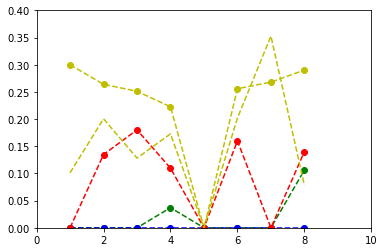

In [10]:
plt.plot([a for a in range(1,9)], l[0], 'yo--')
plt.plot([a for a in range(1,9)], l[1], 'go--')
plt.plot([a for a in range(1,9)], l[2], 'bo--')
plt.plot([a for a in range(1,9)], l[3], 'ro--')
plt.plot([a for a in range(1,9)], l[4], 'y--')
plt.axis([0, 10, 0, 0.4])

ax = plt.gca()
ax.set_autoscale_on(False)
plt.show()
